MERABET Mohamed Malih 22202729, 
MESSAOUDI Nor El Houda 22216866, 
SEOUDI Noha 21813399, 
ZEDDAM Lylia 21812374

#Projet Deep learning
Dans cette partie on apporte des amélioration sur notre modeleBaseLine




# 0-Installation des libraire et mise en palce de google drive 

In [ ]:
!pip install pyyaml h5py #pour sauvegarder le modèle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importation des différentes librairies utiles pour le notebook
#Pour ignorer les warning.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
import numpy as np
import string
import time
import base64
import re
import sys
import copy
import random
from numpy import mean
from numpy import std
from scipy.stats import randint

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from PIL import Image

#Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


# TensorFlow et keras
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,img_to_array, load_img #from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing import image
from tqdm import tqdm
from keras.models import load_model
from sklearn.model_selection import KFold
from keras.layers import Dense
import os  #pour accéder aux fonctionnalité systèmes
import sys 
from os import listdir
from os.path import isfile, join
import cv2  # Library to solve computer vision problems
import glob  # = global is used to return all file paths that match a specific pattern

In [ ]:
# pour monter son Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'
/content


'/content'

# 1-Récupération des jeux de données

In [ ]:
#pour télécharger le zip file 
!wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip

--2022-12-02 09:49:33--  https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7605545 (7.3M) [application/zip]
Saving to: ‘Tiger-Fox-Elephant.zip.2’

Tiger-Fox-Elephant. 100%[===================>]   7.25M  7.48MB/s    in 1.0s    

2022-12-02 09:49:34 (7.48 MB/s) - ‘Tiger-Fox-Elephant.zip.2’ saved [7605545/7605545]



In [ ]:
import zipfile
with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    zip_ref.extractall("Data_Project")

#2- Affichage de jeux de données

----
Pour chaque jeu de donnée il y a un ensemble d'images **positive** et un ensemble d'images **négatives**.
**Par exemple:**
 Dans le répertoire tiger il n'y a que des images de tigre et dans le   répertoire Tiger_negative_class il n'y a que des images d'animaux qui ne correspondent pas à des tigres.

On a 100 image +ve de tiger


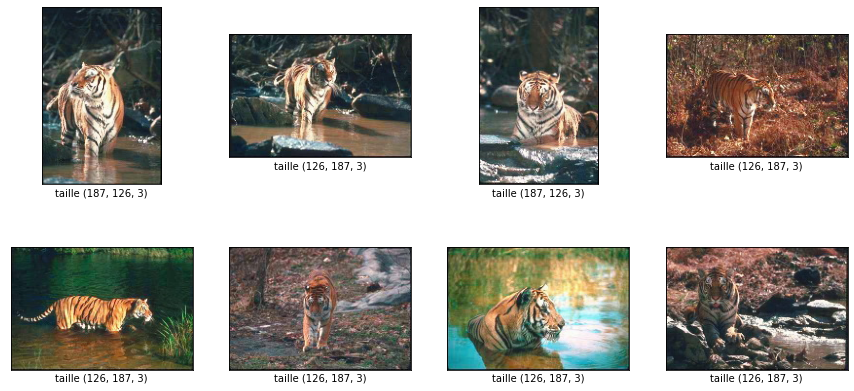

In [ ]:
###Intro 
#Le code ci-dessous permet de visualiser quelques images contenues dans le répertoire tiger.

mypath='Data_Project/Tiger-Fox-Elephant/tiger'  #dans le dossier tiger +ve
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ] #contient toutes les images de tiger 
images = np.empty(len(onlyfiles), dtype=object) #pour créer un tableau vide de taille size et de type object
print ("On a",len(onlyfiles),"image +ve de tiger")
#Remplissage de tableau images, l'image est une matrice de pixels
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
COLUMNS = 8#25 # Nombre d'images à afficher

plt.figure(figsize=(15,15))
for i in range(COLUMNS):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) # cv2 lit, met les images en BGR et matplotlib lit du RGB. il faut donc convertir les couleurs 
    plt.imshow(images[i],cmap=plt.cm.binary)  
    plt.xlabel('taille ' + str(images[i].shape)) 

Nous pouvons constater que les images ne sont pas de la même taille. Il faut donc les convertir pour mieux les traiter. Une manière simple de faire et de faire la conversion lors de la lecture des images : ici nous convertissons toutes les images en 124x124.

#3-Initialisation de fonctions globales qui serviront tout le long de notre étude.

In [ ]:
# constantes globales
IMG_SIZE=124
COLUMNS = 16 # Nombre d'images à afficher

In [ ]:
def plot_curves(histories):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,top = 0.9, wspace = 0.25, hspace = 0)
  for i in range(len(histories)):
    # plot loss
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='red', label='test')  
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='red',label='test')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
  plt.show()

In [ ]:
 """
 Téléchargement de jeux d'entrainement 
 @Param path_data: le chemin vers notre répertoire de données 
 @Param list_classes: la liste de nom de classe volue
 @Return training_data
 """
 def create_training_data(path_data, list_classes):  
  training_data=[]   #Tableau de retour 
  for classes in list_classes: # tiger et tiger_negative
      path = os.path.join(path_data, classes)
      class_num = list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
          training_data.append([new_array, class_num])  # on remplit notre tableau 
        except Exception as e:
          pass  
  return training_data   

 """
 Creation de jeux d'entrainement 
 @Param path_data: le chemin vers notre répertoire de données 
 @Param list_classes: la liste de nom de classe volue
 @Return X,y
 """ 
 def create_X_y (path_data, list_classes):
      # récupération des données
      training_data = create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)  #-1 The new shape should be compatible with the original shape.  
      y=np.array(y)
      return X,y 
 """
 Nettoyage de données : conversion en foat et normalisation 
 @Param xtrain 
 @Param xtest
 @Return xtrain_norm, xtest_norm
 """ 
 def clean_data(x): 
    # convertion d'entier en float
    xtrain_norm = x.astype('float32')
    # normalisation entre 0 et 1
    xtrain_norm = xtrain_norm / 255.0
    return xtrain_norm 

 """
 Affichage de données : 
 @Param X 
 @Param y
 """ 
 def plot_examples(X,y):
  plt.figure(figsize=(15,15))
  for i in range(COLUMNS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cv2 lit, met les images en BGR et matplotlib lit du RGB
    X[i] = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
    plt.imshow(X[i]/255.,cmap=plt.cm.binary)    
    plt.xlabel('classe ' + str(y[i]))

##Definition de notre modèle améliorer

In [ ]:
"""
Pour le modèle baseline nous avons fait un modèle assez simple :
une couche conv2D et un pooling suivi bien entendu par un datten et une couche dense avant d'avoir une couche 2nale avec un softmax
"""
def define_model(opt):
  model = models.Sequential()   # Pour initializer le modèle
  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_1"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_1")) # pour réduire l'échantillonnage
  
  model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='relu',padding="same", strides=1, input_shape=(124, 124, 3),name="Conv2D_2"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="Maxpooling2D_2")) # pour réduire l'échantillonnage

  model.add(Dropout(0.5))  
  model.add(layers.Flatten(input_shape = (124,124), name="Flatten_1"))  # Applatir la matrice de maxPooling 
  
  model.add(layers.Dense(128,activation='relu',name="Dense_2")) # Couche de 50 neuronne avec comme fonction d'activation relu 
  
  model.add(layers.Dense(1,activation = 'sigmoid',name="Dense_final"))  # Couche de sortie 
  model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy']) # To finalise the model and make it completely ready to use.
  return model

###K-Fold

Pour évaluer le modèle nous utilisons un K-fold. Pour que les expérimentations ne durent pas
trop longtemps le nombre de folds par défaut est 2xé à 5 et le nombre d'epochs à 10.Evaluation avec un k-fold

In [ ]:
def evaluate_model(dataX, dataY,nbSplit,nbEpoch,opt): #StratifiedKFold 
  scores, histories = [[],[]], list()
  skfold = KFold(n_splits=nbSplit, random_state= 1, shuffle= True) #K-fold stratifier to have some percentage of each class  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # parcourir les splits du k-fold
  for train_ix, test_ix in skfold.split(dataX):
    # define model
    model = define_model(opt)
    # selection des données
    X_train, y_train = dataX[train_ix], dataY[train_ix]
    X_test, y_test = dataX[test_ix], dataY[test_ix]
    # fit du modele
    history = model.fit(X_train, y_train, epochs=nbEpoch,validation_data=(X_test, y_test), verbose=1)
    # evaluate du modele
    loss, acc = model.evaluate(X_test, y_test, verbose= 0)
    scores[0].append(acc)
    scores[1].append(loss)
    print('accuracy %.3f' % (acc * 100.0))
    print('loss %.3f' % (loss * 100.0))
    histories.append(history)
  print ("***************************************************************")
  print (model.summary())
  return scores, histories

Création de modèle de réseau de neurones :
Ce premier modèle est séquentiel
On a __ couches d'entrée , __couche caché et  
2 couches de sorties vu que on a que 2 classes à prédire.



##Evaluation de Notre Modèle

In [ ]:
"""
La fonction suivante permet de lancer l'ensemble des fonctions précédentes. 
"""
# fonction pour charger, transformer et évaluer le modele
# elle lance n-folds fois l'évaluation et affiche les courbes et résultats
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['tiger','Tiger_negative_class']
def run_evaluation(nb_folds,nb_epoch,opt):
	# load dataset
	X, y = create_X_y(my_path, my_classes)
	# Nettoyage et normalisation
	X = clean_data(X)
	# evaluate model
	scores, histories = evaluate_model(X, y,nb_folds,nb_epoch,opt)
	plot_curves(histories)
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores[0])*100, std(scores[0])*100, len(scores[0])))
	print('Loss: mean=%.3f std=%.3f, n=%d' % (mean(scores[1])*100, std(scores[1])*100, len(scores[1])))

###Tiger 

####Test avec plusieurs optimiseurs


#####Adam

Epoch 1/60
5/5 [==============================] - 1s 55ms/step - loss: 1.2478 - accuracy: 0.4938 - val_loss: 0.6982 - val_accuracy: 0.5750
Epoch 2/60
5/5 [==============================] - 0s 23ms/step - loss: 0.7170 - accuracy: 0.4938 - val_loss: 0.7577 - val_accuracy: 0.4250
Epoch 3/60
5/5 [==============================] - 0s 23ms/step - loss: 0.6912 - accuracy: 0.5125 - val_loss: 0.6891 - val_accuracy: 0.4750
Epoch 4/60
5/5 [==============================] - 0s 21ms/step - loss: 0.6420 - accuracy: 0.7125 - val_loss: 0.6601 - val_accuracy: 0.7000
Epoch 5/60
5/5 [==============================] - 0s 21ms/step - loss: 0.6100 - accuracy: 0.6812 - val_loss: 0.6876 - val_accuracy: 0.5500
Epoch 6/60
5/5 [==============================] - 0s 21ms/step - loss: 0.5776 - accuracy: 0.6438 - val_loss: 0.5865 - val_accuracy: 0.6500
Epoch 7/60
5/5 [==============================] - 0s 20ms/step - loss: 0.5165 - accuracy: 0.7437 - val_loss: 0.5599 - val_accuracy: 0.6750
Epoch 8/60
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



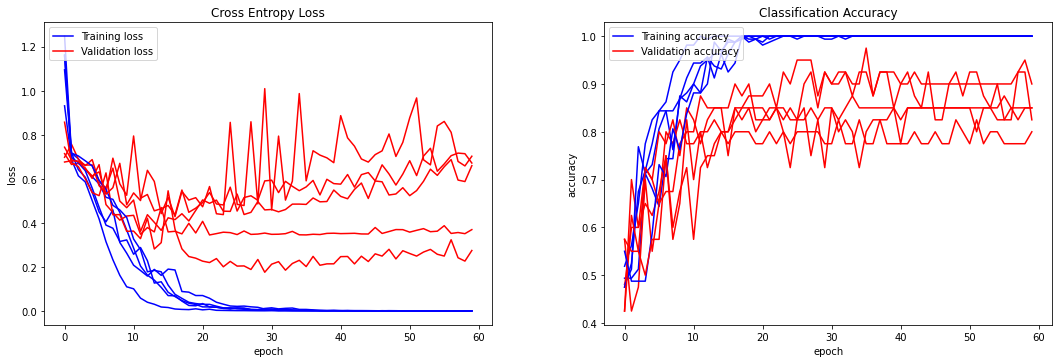

Accuracy: mean=84.500 std=3.317, n=5
Loss: mean=53.604 std=17.742, n=5


In [ ]:
opt = 'adam' 
nbFolds= 5
nbEpoch= 60
run_evaluation(nbFolds,nbEpoch,opt)

#####RMSprop

Epoch 1/20
5/5 [==============================] - 1s 65ms/step - loss: 1.6373 - accuracy: 0.5000 - val_loss: 0.7244 - val_accuracy: 0.4250
Epoch 2/20
5/5 [==============================] - 0s 27ms/step - loss: 0.6821 - accuracy: 0.5188 - val_loss: 0.7094 - val_accuracy: 0.4250
Epoch 3/20
5/5 [==============================] - 0s 26ms/step - loss: 0.6487 - accuracy: 0.6313 - val_loss: 0.6379 - val_accuracy: 0.6000
Epoch 4/20
5/5 [==============================] - 0s 25ms/step - loss: 0.6639 - accuracy: 0.6625 - val_loss: 0.6426 - val_accuracy: 0.7000
Epoch 5/20
5/5 [==============================] - 0s 24ms/step - loss: 0.5056 - accuracy: 0.8500 - val_loss: 0.8626 - val_accuracy: 0.5750
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.6961 - accuracy: 0.6938 - val_loss: 0.6280 - val_accuracy: 0.6250
Epoch 7/20
5/5 [==============================] - 0s 22ms/step - loss: 0.6323 - accuracy: 0.6875 - val_loss: 0.6313 - val_accuracy: 0.7250
Epoch 8/20
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



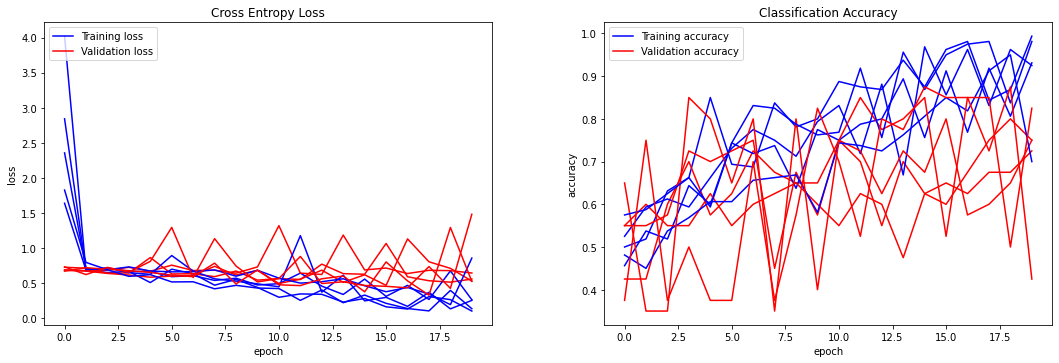

Accuracy: mean=69.500 std=13.910, n=5
Loss: mean=74.543 std=36.977, n=5


In [ ]:
opt = 'RMSprop'
nbFolds= 5
nbEpoch= 20
run_evaluation(nbFolds,nbEpoch,opt)

#####SGD

Epoch 1/20
5/5 [==============================] - 1s 57ms/step - loss: 0.7197 - accuracy: 0.4625 - val_loss: 0.7116 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 0s 23ms/step - loss: 0.6532 - accuracy: 0.6438 - val_loss: 0.6717 - val_accuracy: 0.6250
Epoch 3/20
5/5 [==============================] - 0s 27ms/step - loss: 0.6431 - accuracy: 0.6250 - val_loss: 0.6812 - val_accuracy: 0.6250
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 0.6021 - accuracy: 0.6812 - val_loss: 0.6343 - val_accuracy: 0.6250
Epoch 5/20
5/5 [==============================] - 0s 23ms/step - loss: 0.5375 - accuracy: 0.7563 - val_loss: 0.6188 - val_accuracy: 0.6500
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.4929 - accuracy: 0.7750 - val_loss: 0.7759 - val_accuracy: 0.6250
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 0.5016 - accuracy: 0.7625 - val_loss: 0.6582 - val_accuracy: 0.6250
Epoch 8/20
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



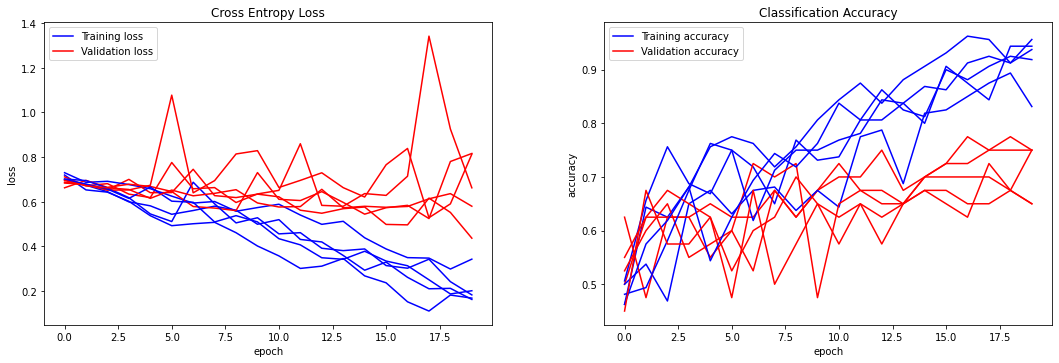

Accuracy: mean=71.000 std=4.899, n=5
Loss: mean=66.176 std=14.425, n=5


In [ ]:
nbFolds= 5
nbEpoch= 20
opt = SGD(learning_rate=0.01, momentum=0.9) #Stochastic gradient descent
run_evaluation(nbFolds,nbEpoch,opt)

###FOX🦊

In [ ]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['fox','Fox_negative_class']

####Test avec plusieurs optimiseurs


#####Adam

Epoch 1/50
5/5 [==============================] - 1s 61ms/step - loss: 1.0746 - accuracy: 0.5250 - val_loss: 0.6970 - val_accuracy: 0.4500
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6587 - accuracy: 0.5875 - val_loss: 0.6447 - val_accuracy: 0.7500
Epoch 3/50
5/5 [==============================] - 0s 25ms/step - loss: 0.5754 - accuracy: 0.7937 - val_loss: 0.5979 - val_accuracy: 0.7500
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 0.4580 - accuracy: 0.8438 - val_loss: 0.5605 - val_accuracy: 0.7250
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 0.3924 - accuracy: 0.8250 - val_loss: 0.5673 - val_accuracy: 0.7500
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 0.3306 - accuracy: 0.8625 - val_loss: 0.5121 - val_accuracy: 0.6250
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2915 - accuracy: 0.8687 - val_loss: 0.4709 - val_accuracy: 0.6750
Epoch 8/50
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



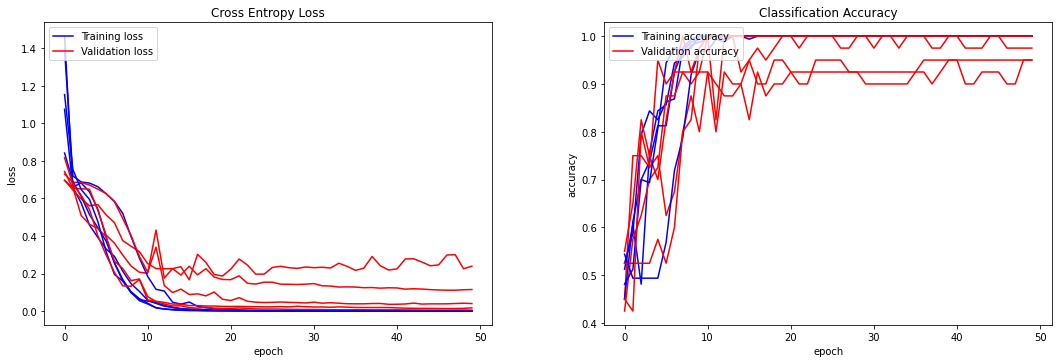

Accuracy: mean=97.500 std=2.236, n=5
Loss: mean=8.312 std=8.671, n=5


In [ ]:
opt = 'adam' 
nbFolds= 5
nbEpoch= 50
run_evaluation(nbFolds,nbEpoch,opt)

#####RMSprop

Epoch 1/70
5/5 [==============================] - 1s 60ms/step - loss: 2.3893 - accuracy: 0.5000 - val_loss: 0.7084 - val_accuracy: 0.4750
Epoch 2/70
5/5 [==============================] - 0s 25ms/step - loss: 0.6812 - accuracy: 0.5688 - val_loss: 0.6584 - val_accuracy: 0.5250
Epoch 3/70
5/5 [==============================] - 0s 23ms/step - loss: 0.6832 - accuracy: 0.5250 - val_loss: 0.6406 - val_accuracy: 0.7000
Epoch 4/70
5/5 [==============================] - 0s 25ms/step - loss: 0.6424 - accuracy: 0.6125 - val_loss: 0.5927 - val_accuracy: 0.6000
Epoch 5/70
5/5 [==============================] - 0s 21ms/step - loss: 0.6335 - accuracy: 0.7063 - val_loss: 0.5499 - val_accuracy: 0.9500
Epoch 6/70
5/5 [==============================] - 0s 22ms/step - loss: 0.4984 - accuracy: 0.8625 - val_loss: 0.4476 - val_accuracy: 0.9000
Epoch 7/70
5/5 [==============================] - 0s 21ms/step - loss: 0.5542 - accuracy: 0.7812 - val_loss: 0.4004 - val_accuracy: 0.9750
Epoch 8/70
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



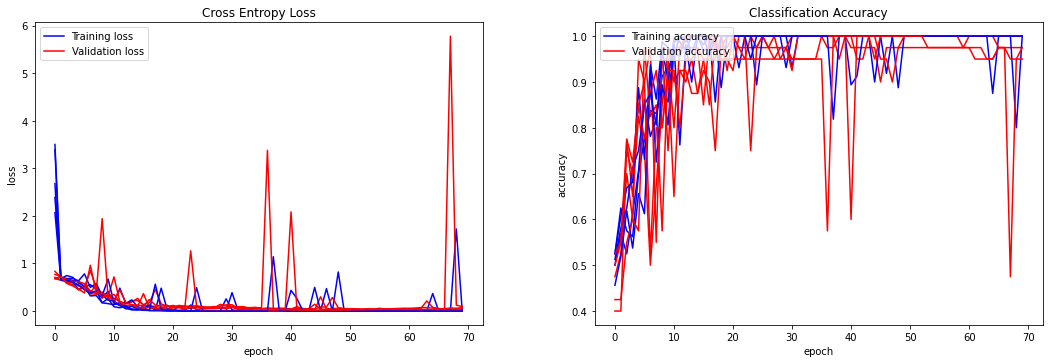

Accuracy: mean=98.000 std=1.871, n=5
Loss: mean=4.825 std=3.213, n=5


In [ ]:
opt = 'RMSprop'
nbFolds= 5
nbEpoch= 70
run_evaluation(nbFolds,nbEpoch,opt)

#####SGD

Epoch 1/50
5/5 [==============================] - 1s 60ms/step - loss: 0.7045 - accuracy: 0.4500 - val_loss: 0.6754 - val_accuracy: 0.6250
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6708 - accuracy: 0.6375 - val_loss: 0.6577 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6647 - accuracy: 0.5750 - val_loss: 0.6313 - val_accuracy: 0.6250
Epoch 4/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6028 - accuracy: 0.6500 - val_loss: 0.7605 - val_accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6784 - accuracy: 0.6250 - val_loss: 0.5961 - val_accuracy: 0.8000
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 0.5945 - accuracy: 0.7312 - val_loss: 0.5881 - val_accuracy: 0.7500
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.5411 - accuracy: 0.7563 - val_loss: 0.6217 - val_accuracy: 0.5750
Epoch 8/50
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



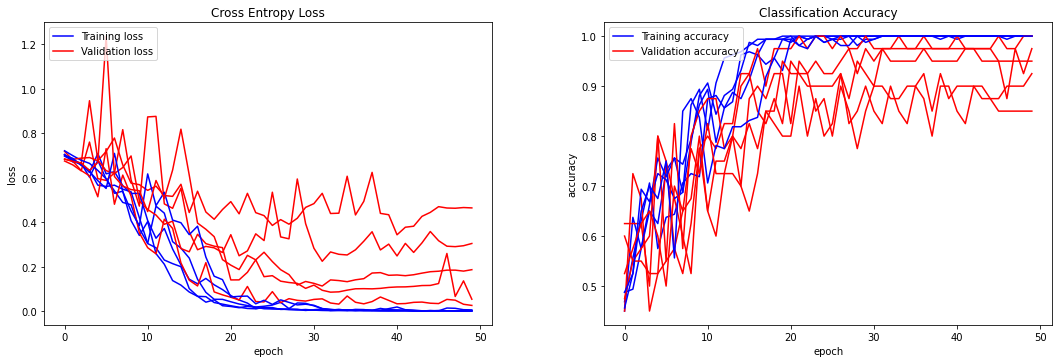

Accuracy: mean=94.000 std=5.148, n=5
Loss: mean=20.720 std=16.270, n=5


In [ ]:
nbFolds= 5
nbEpoch= 50
opt = SGD(learning_rate=0.01, momentum=0.9) #Stochastic gradient descent
run_evaluation(nbFolds,nbEpoch,opt)

###Elephant🐘

In [ ]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['elephant','Elephant_negative_class']

####Test avec plusieurs optimiseurs


#####Adam

Epoch 1/70
5/5 [==============================] - 1s 56ms/step - loss: 1.3151 - accuracy: 0.5125 - val_loss: 0.7498 - val_accuracy: 0.4750
Epoch 2/70
5/5 [==============================] - 0s 25ms/step - loss: 0.7076 - accuracy: 0.5063 - val_loss: 0.6910 - val_accuracy: 0.4750
Epoch 3/70
5/5 [==============================] - 0s 24ms/step - loss: 0.6822 - accuracy: 0.5063 - val_loss: 0.6808 - val_accuracy: 0.4750
Epoch 4/70
5/5 [==============================] - 0s 24ms/step - loss: 0.6671 - accuracy: 0.5063 - val_loss: 0.6680 - val_accuracy: 0.4750
Epoch 5/70
5/5 [==============================] - 0s 23ms/step - loss: 0.6334 - accuracy: 0.5063 - val_loss: 0.6381 - val_accuracy: 0.4750
Epoch 6/70
5/5 [==============================] - 0s 21ms/step - loss: 0.6109 - accuracy: 0.6125 - val_loss: 0.5959 - val_accuracy: 0.7000
Epoch 7/70
5/5 [==============================] - 0s 22ms/step - loss: 0.5987 - accuracy: 0.7312 - val_loss: 0.5955 - val_accuracy: 0.4750
Epoch 8/70
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



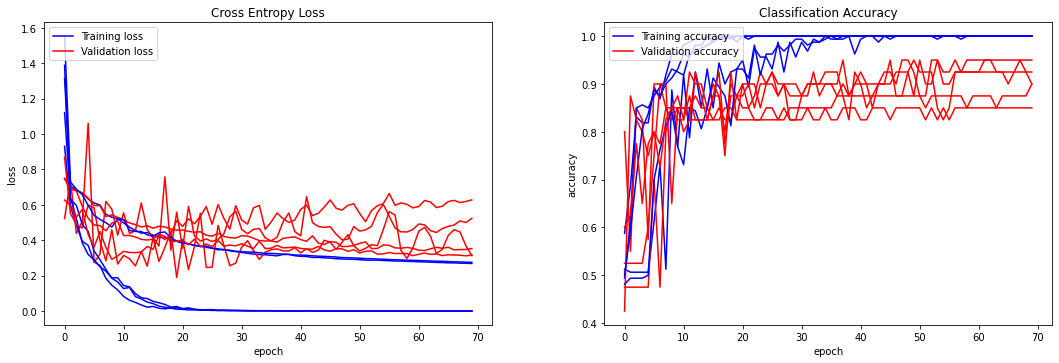

Accuracy: mean=90.500 std=3.317, n=5
Loss: mean=42.709 std=12.679, n=5


In [ ]:
opt = 'adam' 
nbFolds= 5
nbEpoch= 70
run_evaluation(nbFolds,nbEpoch,opt)

#####RMSprop

Epoch 1/70
5/5 [==============================] - 1s 59ms/step - loss: 2.2997 - accuracy: 0.5500 - val_loss: 0.7095 - val_accuracy: 0.4250
Epoch 2/70
5/5 [==============================] - 0s 25ms/step - loss: 0.6640 - accuracy: 0.7000 - val_loss: 0.6071 - val_accuracy: 0.8000
Epoch 3/70
5/5 [==============================] - 0s 25ms/step - loss: 0.7689 - accuracy: 0.7000 - val_loss: 0.5625 - val_accuracy: 0.9250
Epoch 4/70
5/5 [==============================] - 0s 24ms/step - loss: 0.5580 - accuracy: 0.7625 - val_loss: 0.4727 - val_accuracy: 0.8250
Epoch 5/70
5/5 [==============================] - 0s 21ms/step - loss: 0.5093 - accuracy: 0.7625 - val_loss: 0.3876 - val_accuracy: 0.9500
Epoch 6/70
5/5 [==============================] - 0s 23ms/step - loss: 0.6005 - accuracy: 0.7000 - val_loss: 0.4130 - val_accuracy: 0.8000
Epoch 7/70
5/5 [==============================] - 0s 21ms/step - loss: 0.4359 - accuracy: 0.8000 - val_loss: 0.4541 - val_accuracy: 0.7500
Epoch 8/70
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



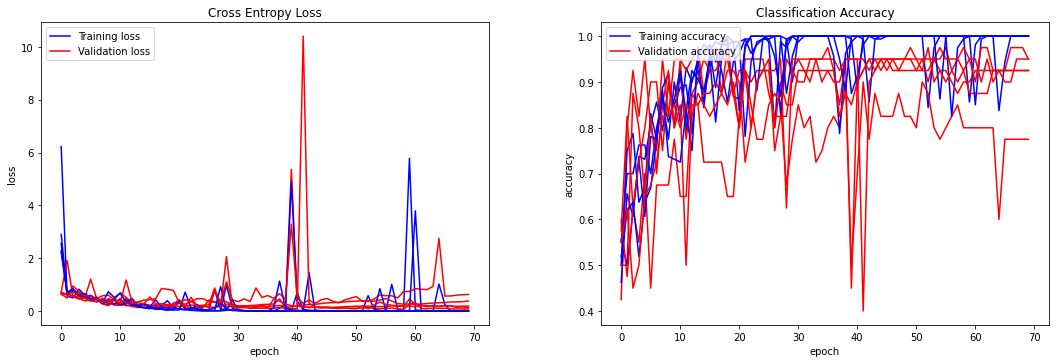

Accuracy: mean=90.500 std=6.595, n=5
Loss: mean=28.136 std=20.140, n=5


In [ ]:
opt = 'RMSprop'
nbFolds= 5
nbEpoch= 70
run_evaluation(nbFolds,nbEpoch,opt)

#####SGD

Epoch 1/20
5/5 [==============================] - 1s 57ms/step - loss: 0.7013 - accuracy: 0.4688 - val_loss: 0.6322 - val_accuracy: 0.8500
Epoch 2/20
5/5 [==============================] - 0s 25ms/step - loss: 0.6366 - accuracy: 0.7063 - val_loss: 0.5496 - val_accuracy: 0.8500
Epoch 3/20
5/5 [==============================] - 0s 23ms/step - loss: 0.5412 - accuracy: 0.7437 - val_loss: 0.5372 - val_accuracy: 0.6750
Epoch 4/20
5/5 [==============================] - 0s 23ms/step - loss: 0.4251 - accuracy: 0.8188 - val_loss: 0.3829 - val_accuracy: 0.8750
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 0.3481 - accuracy: 0.8562 - val_loss: 0.6252 - val_accuracy: 0.7500
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.3208 - accuracy: 0.8625 - val_loss: 0.5777 - val_accuracy: 0.7750
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 0.2417 - accuracy: 0.8875 - val_loss: 0.5148 - val_accuracy: 0.8250
Epoch 8/20
5/5 [===========

<ipython-input-59-ecc94586af1e>:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-59-ecc94586af1e>:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



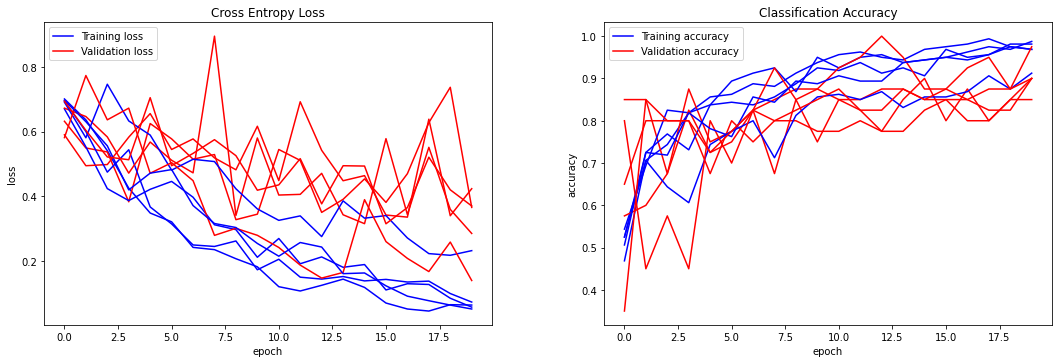

Accuracy: mean=90.500 std=4.000, n=5
Loss: mean=31.659 std=9.917, n=5


In [ ]:
nbFolds= 5
nbEpoch= 20
opt = SGD(learning_rate=0.01, momentum=0.9) #Stochastic gradient descent
run_evaluation(nbFolds,nbEpoch,opt)